In [64]:
def posmediapases(id_partido,equipo):

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Arc

    matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
    matches['union']=range(len(matches))
    
    #Separamos los datos de la columna home_team y le añadimos la columna union
    local1=matches['home_team'].apply(pd.Series)
    local1['union']=range(len(matches))

    #Unimos los dataframes 
    local2=pd.merge(matches, local1,how='outer',on='union')

    #Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
    fila1=local2.loc[local2['match_id']==id_partido]

    jornada=fila1.iloc[0,12]
    fecha=fila1.iloc[0,1]

    #DF con todos los eventos del partido
    events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
    dfeventos=pd.read_json(events)

    #DF con los eventos del equipo elegido
    dfeventos['equipo'] = dfeventos['team'].apply(lambda x: x.get('name'))
    dfeventospropios=dfeventos.loc[dfeventos['equipo']==equipo]

    #DF con los pases propios en juego corrido
    dfeventospropios['tipoevento'] = dfeventospropios['type'].apply(lambda x: x.get('name'))
    dfpases=dfeventospropios.loc[dfeventospropios['tipoevento']=="Pass"]
    dfpases['fase'] = dfpases['play_pattern'].apply(lambda x: x.get('name'))
    dfpases=dfpases.loc[dfpases['fase']=="Regular Play"]
    dfpases=dfpases[['location','player']]
    dfpases['name']=dfpases['player'].apply(lambda x: x.get('name'))
    dfpases['x'] = dfpases['location'].apply(lambda x: x[0])
    dfpases['y'] = dfpases['location'].apply(lambda x: x[1])
    dfpases['y'] = 80 - dfpases['y']
    dfpases.drop(columns=['location','player'], inplace=True)

    #DF con número de pases y posición media por jugadora
    jugadoras=dfpases.name.unique()
    listagrande=[]
    for jugadora in jugadoras:
        dfjugadora=dfpases.loc[dfpases['name'] == jugadora]
        listax=dfjugadora['x'].tolist()
        mediax=round(sum(listax)/len(listax),2)
        listay=dfjugadora['y'].tolist()
        mediay=round(sum(listay)/len(listay),2)
        numpases=len(dfjugadora)
        a=(jugadora,mediax,mediay,numpases)
        listagrande.append(a)
    df=pd.DataFrame(listagrande,columns=['Nombre','xmedia','ymedia','numpases'])

    fig, ax = plt.subplots(figsize=(18,14))

    plt.scatter(x=df['xmedia'],y=df['ymedia'],s = df['numpases']*20,c='#CC0000',alpha=0.6)

    #StatsBomb Pitch
    # Pitch Outline & Centre Line 
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black") 
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[80,0], color="black")

    # Left Penalty Area
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")
    plt.plot([18,18],[18,62],color="black")

    # Right Penalty Area
    plt.plot([120,102],[62,62],color="black")
    plt.plot([120,102],[18,18],color="black")
    plt.plot([102,102],[18,62],color="black")

    # Left 6-yard Box
    plt.plot([0,6],[50,50],color="black")
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")

    # Right 6-yard Box 
    plt.plot([120,114],[30,30],color="black")
    plt.plot([120,114],[50,50],color="black")
    plt.plot([114,114],[30,50],color="black")

    # Prepare Circles OK
    centreCircle = plt.Circle((60,40),9.15,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.6,color="black")
    leftPenSpot = plt.Circle((12,40),0.6,color="black")
    rightPenSpot = plt.Circle((108,40),0.6,color="black")

    # Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    # Prepare Arcs based on penalty Spots 
    leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")


    # Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    ax.text(60, 92, s = "Jornada {}\n{}".format(jornada,fecha), rotation = 0, size = 15, ha='center', family='bahnschrift')
    ax.text(60, 87.5, s = "Posicion media de pases: {}".format(equipo), rotation = 0, size = 25, bbox=dict(facecolor='#CC0000', alpha=0.2), ha='center', family='bahnschrift')
    for i in range(len(df)):
        ax.text(df.iloc[i,1], (df.iloc[i,2])+3, s = df.iloc[i,0], size = 10, ha='center', family='bahnschrift',color='#CC0000')

    g2 = plt.scatter([],[], s=500, marker='o', color='#CC0000',alpha=0.4)
    g3 = plt.scatter([],[], s=0.0001, marker='o', color='#CC0000',alpha=0)


    plt.legend((g2,g3),
       ('Incidencia en el juego (#pases)', ''),
       scatterpoints=1,
       loc=(0.375,0.97),
       ncol=5, prop=dict(family='bahnschrift',weight=500,size=11),
       labelspacing=-3,framealpha=1,edgecolor='black',borderpad=1)

    dfordenado=df.sort_values(by='xmedia')
    xmin=dfordenado.iloc[1,1]
    xmax=dfordenado.iloc[-1,1]

    plt.plot([xmin,xmin],[0,80],color='#CC0000', marker='x', linestyle='dashed',linewidth=2, markersize=1,alpha=0.4)
    plt.plot([xmax,xmax],[0,80],color='#CC0000', marker='x', linestyle='dashed',linewidth=2, markersize=1,alpha=0.4)

    plt.axis('off')
    plt.show()

In [74]:
def posmediaeventos(id_partido,equipo):

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Arc

    matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
    matches['union']=range(len(matches))
    
    #Separamos los datos de la columna home_team y le añadimos la columna union
    local1=matches['home_team'].apply(pd.Series)
    local1['union']=range(len(matches))

    #Unimos los dataframes 
    local2=pd.merge(matches, local1,how='outer',on='union')

    #Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
    fila1=local2.loc[local2['match_id']==id_partido]

    jornada=fila1.iloc[0,12]
    fecha=fila1.iloc[0,1]

    #DF con todos los eventos del partido
    events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
    dfeventos=pd.read_json(events)

    #DF con los eventos del equipo elegido
    dfeventos['equipo'] = dfeventos['team'].apply(lambda x: x.get('name'))
    dfpases=dfeventos.loc[dfeventos['equipo']==equipo]

    #DF con los pases propios en juego corrido
    #dfeventospropios['tipoevento'] = dfeventospropios['type'].apply(lambda x: x.get('name'))
    #dfpases=dfeventospropios.loc[dfeventospropios['tipoevento']=="Pass"]
    dfpases['fase'] = dfpases['play_pattern'].apply(lambda x: x.get('name'))
    dfpases=dfpases.loc[dfpases['fase']=="Regular Play"]
    dfpases=dfpases[['location','player']]
    dfpases.dropna(inplace=True)
    dfpases['name']=dfpases['player'].apply(lambda x: x.get('name'))
    dfpases['x'] = dfpases['location'].apply(lambda x: x[0])
    dfpases['y'] = dfpases['location'].apply(lambda x: x[1])
    dfpases['y'] = 80 - dfpases['y']
    dfpases.drop(columns=['location','player'], inplace=True)

    #DF con número de pases y posición media por jugadora
    jugadoras=dfpases.name.unique()
    listagrande=[]
    for jugadora in jugadoras:
        dfjugadora=dfpases.loc[dfpases['name'] == jugadora]
        listax=dfjugadora['x'].tolist()
        mediax=round(sum(listax)/len(listax),2)
        listay=dfjugadora['y'].tolist()
        mediay=round(sum(listay)/len(listay),2)
        numpases=len(dfjugadora)
        a=(jugadora,mediax,mediay,numpases)
        listagrande.append(a)
    df=pd.DataFrame(listagrande,columns=['Nombre','xmedia','ymedia','numpases'])

    fig, ax = plt.subplots(figsize=(18,14))

    plt.scatter(x=df['xmedia'],y=df['ymedia'],s = 150,c='#CC0000',alpha=0.6)

    #StatsBomb Pitch
    # Pitch Outline & Centre Line 
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black") 
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[80,0], color="black")

    # Left Penalty Area
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")
    plt.plot([18,18],[18,62],color="black")

    # Right Penalty Area
    plt.plot([120,102],[62,62],color="black")
    plt.plot([120,102],[18,18],color="black")
    plt.plot([102,102],[18,62],color="black")

    # Left 6-yard Box
    plt.plot([0,6],[50,50],color="black")
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")

    # Right 6-yard Box 
    plt.plot([120,114],[30,30],color="black")
    plt.plot([120,114],[50,50],color="black")
    plt.plot([114,114],[30,50],color="black")

    # Prepare Circles OK
    centreCircle = plt.Circle((60,40),9.15,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.6,color="black")
    leftPenSpot = plt.Circle((12,40),0.6,color="black")
    rightPenSpot = plt.Circle((108,40),0.6,color="black")

    # Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    # Prepare Arcs based on penalty Spots 
    leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")


    # Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    ax.text(60, 88, s = "Jornada {}\n{}".format(jornada,fecha), rotation = 0, size = 15, ha='center', family='bahnschrift')
    ax.text(60, 83.5, s = "Posicion media de eventos: {}".format(equipo), rotation = 0, size = 25, bbox=dict(facecolor='#CC0000', alpha=0.2), ha='center', family='bahnschrift')
    for i in range(len(df)):
        ax.text(df.iloc[i,1], (df.iloc[i,2])+3, s = df.iloc[i,0], size = 10, ha='center', family='bahnschrift',color='#CC0000')

    g2 = plt.scatter([],[], s=500, marker='o', color='#CC0000',alpha=0.4)
    g3 = plt.scatter([],[], s=0.0001, marker='o', color='#CC0000',alpha=0)

    dfordenado=df.sort_values(by='xmedia')
    xmin=dfordenado.iloc[1,1]
    xmax=dfordenado.iloc[-1,1]

    plt.plot([xmin,xmin],[0,80],color='#CC0000', marker='x', linestyle='dashed',linewidth=2, markersize=1,alpha=0.4)
    plt.plot([xmax,xmax],[0,80],color='#CC0000', marker='x', linestyle='dashed',linewidth=2, markersize=1,alpha=0.4)

    plt.axis('off')
    plt.show()

C:\Users\gonza\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gonza\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


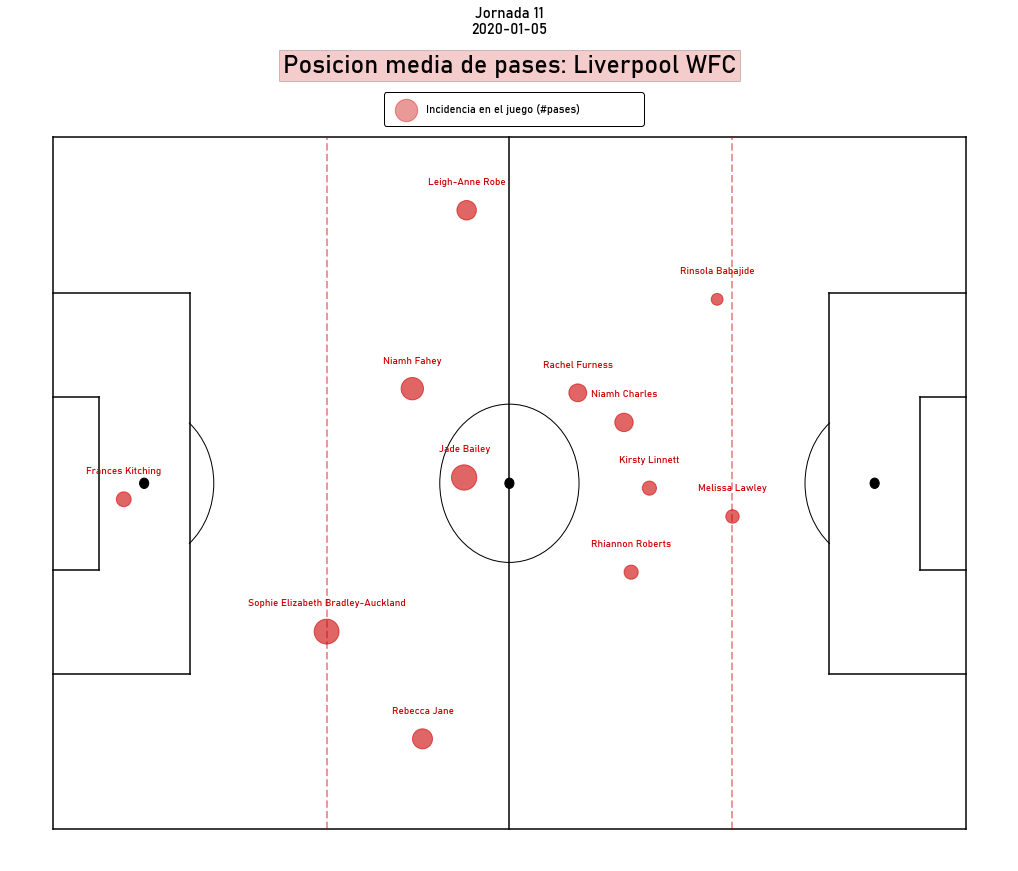

In [75]:
posmediapases(2275054,"Liverpool WFC")

C:\Users\gonza\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


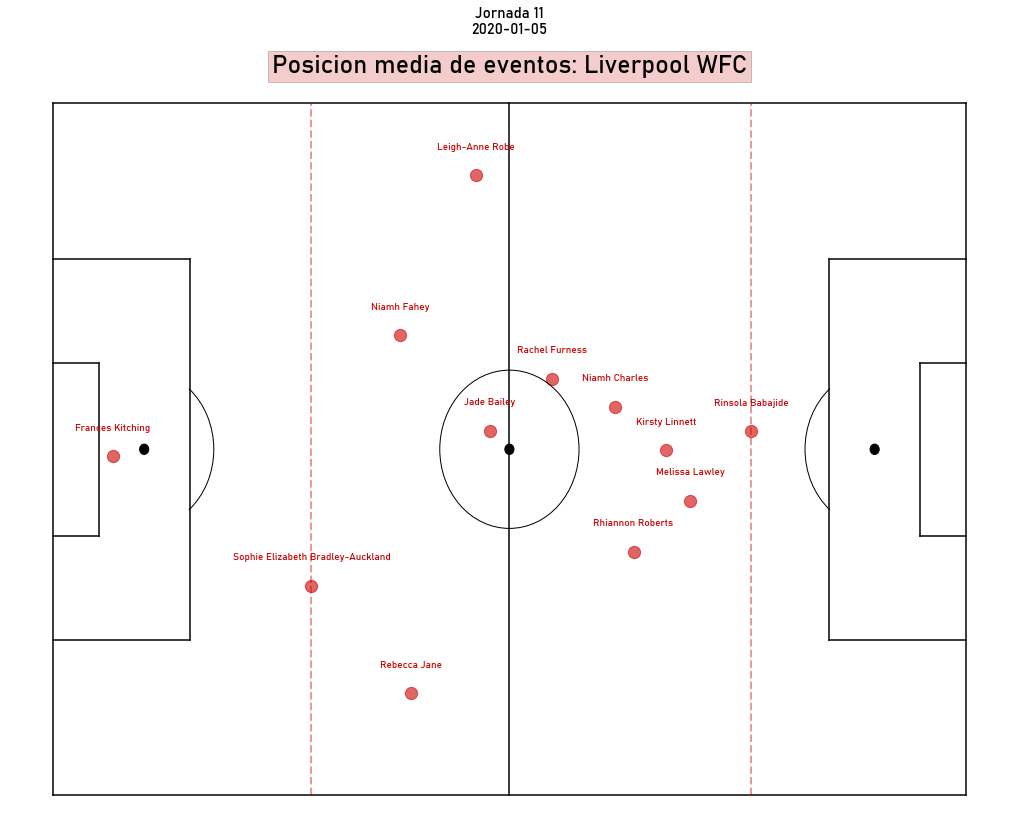

In [76]:
posmediaeventos(2275054,"Liverpool WFC")